# The Effect of Distance on Field Goals

As the main form of scoring in basketball, field goals dictate the flow of games. 
Shots near the basket should theoretically have a higher percentage of conversion than farther shots.

At a certain distance, however field goals are worth even more. Many players are specialists at these three point field goals, hitting them at a higher than expected clip. Players, like Stephen Curry, Klay Thompson, Eric Gordon, etc. have a very high 3PFG% (three point field goal percentage).

In order to determine these trends in distance, we visualize these field goals based on shot range.

## Visualizing Field Goals

Using Professor Oh's framework, we:

1. Gather data on all current NBA teams and players.
2. Create interactive widgets which determine shot distance and if the shot was made or missed.
3. Scrape the shot data and player picture.
5. Plot court and shot data.

In [20]:
%matplotlib inline

import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ipywidgets import interact, FloatSlider, Dropdown, Button, RadioButtons, Select, ToggleButtons
from matplotlib.offsetbox import  OffsetImage
from IPython.display import clear_output

In [16]:
def get_nba_data(endpt, params, return_url=False):

    ## endpt: https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation
    ## params: dictionary of parameters: i.e., {'LeagueID':'00'}
    
    from pandas import DataFrame
    from urllib.parse import urlencode
    import json
    
    useragent = "\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9\""
    dataurl = "\"" + "http://stats.nba.com/stats/" + endpt + "?" + urlencode(params) + "\""
    
    # for debugging: just return the url
    if return_url:
        return(dataurl)
    
    jsonstr = !wget -q -O - --user-agent={useragent} {dataurl}
    
    data = json.loads(jsonstr[0])
    
    h = data['resultSets'][0]['headers']
    d = data['resultSets'][0]['rowSet']
    
    return(DataFrame(d, columns=h))

In [17]:
params = {'LeagueID':'00', 'Season': '2016-17', 'IsOnlyCurrentSeason': '0'}
players = get_nba_data('commonallplayers', params)

params = {'LeagueID':'00'}
teams = get_nba_data('commonTeamYears', params)

playersNoNA = players[players.TEAM_ID != 0]

plyr_by_team_dd = dict()

for t, p in playersNoNA.groupby('TEAM_ID'):
    
    plyr_by_team_dd[t] = dict(zip(p.DISPLAY_LAST_COMMA_FIRST, p.PERSON_ID))

plyr_by_team_dd


team_dd_text = teams.ABBREVIATION
team_dd = dict(zip(teams.ABBREVIATION, teams.TEAM_ID))

plyr_dd_text = players.DISPLAY_LAST_COMMA_FIRST
plyr_dd_id = players.PERSON_ID
plyr_dd = dict(zip(plyr_dd_text, plyr_dd_id))

In [4]:
## code is from http://savvastjortjoglou.com/nba-shot-sharts.html
def draw_court(ax=None, color='black', lw=1, outer_lines=False):
    
    from matplotlib.patches import Circle, Rectangle, Arc
    from matplotlib.pyplot import gca
    
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
 
    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, 0, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-219, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((219, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.5, theta2=157.5, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

Dropdown(index=8, options={'ATL': 1610612737, 'BOS': 1610612738, 'CLE': 1610612739, 'NOP': 1610612740, 'CHI': 1610612741, 'DAL': 1610612742, 'DEN': 1610612743, 'GSW': 1610612744, 'HOU': 1610612745, 'LAC': 1610612746, 'LAL': 1610612747, 'MIA': 1610612748, 'MIL': 1610612749, 'MIN': 1610612750, 'BKN': 1610612751, 'NYK': 1610612752, 'ORL': 1610612753, 'IND': 1610612754, 'PHI': 1610612755, 'PHX': 1610612756, 'POR': 1610612757, 'SAC': 1610612758, 'SAS': 1610612759, 'OKC': 1610612760, 'TOR': 1610612761, 'UTA': 1610612762, 'MEM': 1610612763, 'WAS': 1610612764, 'DET': 1610612765, 'CHA': 1610612766, None: 1610610035}, value=1610612745)

Dropdown(options={'Anderson, Ryan': 201583, 'Ariza, Trevor': 2772, 'Beverley, Patrick': 201976, 'Brown, Bobby': 201628, 'Capela, Clint': 203991, 'Dekker, Sam': 1626155, 'Gordon, Eric': 201569, 'Harden, James': 201935, 'Harrell, Montrezl': 1626149, 'Nene': 2403, 'Onuaku, Chinanu': 1627778, 'Taylor, Isaiah': 1627819, 'Williams, Lou': 101150, 'Williams, Troy': 1627786, 'Wiltjer, Kyle': 1627787}, value=201583)

ToggleButtons(description='Shot Attempts', index=1, options=('All Shots', 'Made Shots', 'Missed Shots'), value='Made Shots')

RadioButtons(index=1, options=('Less than 8 ft.', '8 - 16 ft.', '16 - 24 ft.', '24+ ft.', 'All'), value='8 - 16 ft.')

Button(description='PLOT SHOTS', icon='cross', style=ButtonStyle())

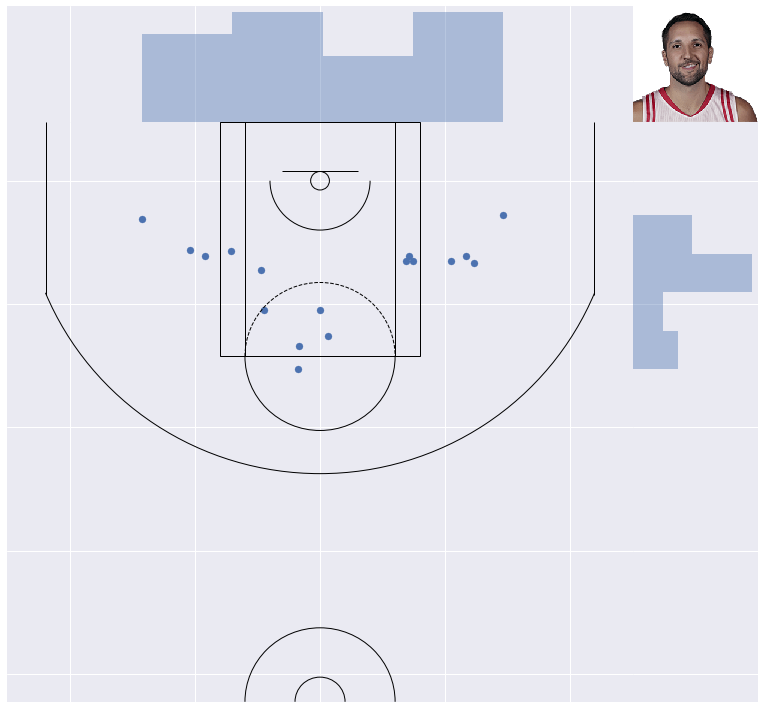

In [26]:
selected = 'HOU'

team_menu = Dropdown(options = team_dd, label=selected)
plyr_menu = Dropdown(options = plyr_by_team_dd[team_dd[selected]])
shot_menu = RadioButtons(options = ['Less than 8 ft.', '8 - 16 ft.', '16 - 24 ft.', '24+ ft.', 'All'])
attempt_menu = ToggleButtons(options = ['All Shots', 'Made Shots', 'Missed Shots'], description = 'Shot Attempts')

def update_team(change):
    plyr_menu.options = plyr_by_team_dd[change['new']]

team_menu.observe(update_team, names='value')

button = Button(description = 'PLOT SHOTS', icon = 'cross')

def get_shotchart(change):
    
    clear_output()
    display(team_menu, plyr_menu, attempt_menu, shot_menu, button)
    params = {'PlayerID':plyr_menu.value,
          'PlayerPosition':'',
          'Season':'2016-17',
          'ContextMeasure':'FGA',
          'DateFrom':'',
          'DateTo':'',
          'GameID':'',
          'GameSegment':'',
          'LastNGames':'0',
          'LeagueID':'00',
          'Location':'',
          'Month':'0',
          'OpponentTeamID':'0',
          'Outcome':'',
          'Period':'0',
          'Position':'',
          'RookieYear':'',
          'SeasonSegment':'',
          'SeasonType':'Regular Season',
          'TeamID':'0',
          'VsConference':'',
          'VsDivision':''}
    shotdata = get_nba_data('shotchartdetail', params)
    
    made = shotdata[shotdata.SHOT_MADE_FLAG == 1]
    missed = shotdata[shotdata.SHOT_MADE_FLAG == 0]
    
    not8 = shotdata[shotdata.SHOT_ZONE_RANGE == 'Less Than 8 ft.']
    eight = shotdata[shotdata.SHOT_ZONE_RANGE == '8-16 ft.']
    sixteen = shotdata[shotdata.SHOT_ZONE_RANGE == '16-24 ft.']
    twentyfour = shotdata[shotdata.SHOT_ZONE_RANGE == '24+ ft.']
    
    made1 = shotdata[(shotdata.SHOT_ZONE_RANGE == 'Less Than 8 ft.') & (shotdata.SHOT_MADE_FLAG == 1)]
    made8 = shotdata[(shotdata.SHOT_ZONE_RANGE == '8-16 ft.') & (shotdata.SHOT_MADE_FLAG == 1)]
    made16 = shotdata[(shotdata.SHOT_ZONE_RANGE == '16-24 ft.') & (shotdata.SHOT_MADE_FLAG == 1)]
    made24 = shotdata[(shotdata.SHOT_ZONE_RANGE == '24+ ft.') & (shotdata.SHOT_MADE_FLAG == 1)]
    missed1 = shotdata[(shotdata.SHOT_ZONE_RANGE == 'Less Than 8 ft.') & (shotdata.SHOT_MADE_FLAG == 0)]
    missed8 = shotdata[(shotdata.SHOT_ZONE_RANGE == '8-16 ft.') & (shotdata.SHOT_MADE_FLAG == 0)]
    missed16 = shotdata[(shotdata.SHOT_ZONE_RANGE == '16-24 ft.') & (shotdata.SHOT_MADE_FLAG == 0)]
    missed24 = shotdata[(shotdata.SHOT_ZONE_RANGE == '24+ ft.') & (shotdata.SHOT_MADE_FLAG == 0)]
    
    if shot_menu.value == 'Less than 8 ft.' and attempt_menu.value == 'Made Shots':
        joint_shot_chart = sns.jointplot(x="LOC_X", y="LOC_Y", data=made1, stat_func=None,
                                 kind='scatter', space=0, alpha=1, marker = 'o')

        joint_shot_chart.fig.set_size_inches(12,11)
    
    elif shot_menu.value == '8 - 16 ft.' and attempt_menu.value == 'Made Shots':
        joint_shot_chart = sns.jointplot(x="LOC_X", y="LOC_Y", data=made8, stat_func=None,
                                 kind='scatter', space=0, alpha=1, marker = 'o')

        joint_shot_chart.fig.set_size_inches(12,11)
    
    elif shot_menu.value == '16 - 24 ft.' and attempt_menu.value == 'Made Shots':
        joint_shot_chart = sns.jointplot(x="LOC_X", y="LOC_Y", data=made16, stat_func=None,
                                 kind='scatter', space=0, alpha=1, marker = 'o')

        joint_shot_chart.fig.set_size_inches(12,11)
    
    elif shot_menu.value == '24+ ft.' and attempt_menu.value == 'Made Shots':
        joint_shot_chart = sns.jointplot(x="LOC_X", y="LOC_Y", data=made24, stat_func=None,
                                 kind='scatter', space=0, alpha=1, marker = 'o')

        joint_shot_chart.fig.set_size_inches(12,11)
        
    elif shot_menu.value == 'Less than 8 ft.' and attempt_menu.value == 'Missed Shots':
        joint_shot_chart = sns.jointplot(x="LOC_X", y="LOC_Y", data=missed1, stat_func=None,
                                 kind='scatter', space=0, alpha=1, marker = 'x')

        joint_shot_chart.fig.set_size_inches(12,11)
        
    elif shot_menu.value == '8 - 16 ft.' and attempt_menu.value == 'Missed Shots':
        joint_shot_chart = sns.jointplot(x="LOC_X", y="LOC_Y", data=missed8, stat_func=None,
                                 kind='scatter', space=0, alpha=1, marker = 'x')

        joint_shot_chart.fig.set_size_inches(12,11)
        
    elif shot_menu.value == '16 - 24 ft.' and attempt_menu.value == 'Missed Shots':
        joint_shot_chart = sns.jointplot(x="LOC_X", y="LOC_Y", data=missed16, stat_func=None,
                                 kind='scatter', space=0, alpha=1, marker = 'x')

        joint_shot_chart.fig.set_size_inches(12,11)
    
    elif shot_menu.value == '24+ ft.' and attempt_menu.value == 'Missed Shots':
        joint_shot_chart = sns.jointplot(x="LOC_X", y="LOC_Y", data=missed24, stat_func=None,
                                 kind='scatter', space=0, alpha=1, marker = 'x')

        joint_shot_chart.fig.set_size_inches(12,11)
    
    elif shot_menu.value == 'Less than 8 ft.' and attempt_menu.value == 'All Shots':

        joint_shot_chart = sns.jointplot(x="LOC_X", y="LOC_Y", data=not8, stat_func=None,
                                 kind='scatter', space=0, alpha=1)

        joint_shot_chart.fig.set_size_inches(12,11)
        
    elif shot_menu.value == '8 - 16 ft.' and attempt_menu.value == 'All Shots':
        joint_shot_chart = sns.jointplot(x="LOC_X", y="LOC_Y", data=eight, stat_func=None,
                                 kind='scatter', space=0, alpha=1)

        joint_shot_chart.fig.set_size_inches(12,11)
        
    elif shot_menu.value == '16 - 24 ft.' and attempt_menu.value == 'All Shots':
        joint_shot_chart = sns.jointplot(x="LOC_X", y="LOC_Y", data=sixteen, stat_func=None,
                                 kind='scatter', space=0, alpha=1)

        joint_shot_chart.fig.set_size_inches(12,11)    
    
    elif shot_menu.value == '24+ ft.' and attempt_menu.value == 'All Shots':
        joint_shot_chart = sns.jointplot(x="LOC_X", y="LOC_Y", data=twentyfour, stat_func=None,
                                 kind='scatter', space=0, alpha=1)

        joint_shot_chart.fig.set_size_inches(12,11)
        
    elif shot_menu.value == 'All' and attempt_menu.value == 'Made Shots':
        joint_shot_chart = sns.jointplot(x="LOC_X", y="LOC_Y", data=made, stat_func=None,
                                 kind='scatter', space=0, alpha=1, marker = 'o')

        joint_shot_chart.fig.set_size_inches(12,11)
        
    elif shot_menu.value == 'All' and attempt_menu.value == 'Missed Shots':
        joint_shot_chart = sns.jointplot(x="LOC_X", y="LOC_Y", data=missed, stat_func=None,
                                 kind='scatter', space=0, alpha=1, marker = 'x')

        joint_shot_chart.fig.set_size_inches(12,11)
        
    else: 
        joint_shot_chart = sns.jointplot(x="LOC_X", y="LOC_Y", data=shotdata, stat_func=None,
                                 kind='scatter', space=0, alpha=1)

        joint_shot_chart.fig.set_size_inches(12,11)

    ax = joint_shot_chart.ax_joint
    draw_court(ax)
    
    ax.set_xlim(-250,250)
    ax.set_ylim(422.5, -47.5)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelbottom=False, labelleft=False)
    

    pic = urllib.request.urlretrieve('http://stats.nba.com/media/players/230x185/' + str(plyr_menu.value) + '.png')
    picplot = plt.imread(pic[0])
    img = OffsetImage(picplot, zoom=0.6)

    img.set_offset((620,587))

    ax.add_artist(img)
    plt.show()
    
button.on_click(get_shotchart)
display(team_menu, plyr_menu, attempt_menu, shot_menu, button)


### sometimes the widget bugs out and gets a 'list index error'. hitting the button again seems to fix it. i'm not too sure why it does this

## Split - Apply- Combine

Using the current player, we grab their data, and determine their field goal percentage.

1. Split shot attempt data and shot made data by shot distance.
2. Divide made shots by total attempts.
3. Find field goal percentage by distance.
4. Plot bar graph.

In [6]:
params = {'PlayerID':plyr_menu.value,
          'PlayerPosition':'',
          'Season':'2016-17',
          'ContextMeasure':'FGA',
          'DateFrom':'',
          'DateTo':'',
          'GameID':'',
          'GameSegment':'',
          'LastNGames':'0',
          'LeagueID':'00',
          'Location':'',
          'Month':'0',
          'OpponentTeamID':'0',
          'Outcome':'',
          'Period':'0',
          'Position':'',
          'RookieYear':'',
          'SeasonSegment':'',
          'SeasonType':'Regular Season',
          'TeamID':'0',
          'VsConference':'',
          'VsDivision':''}

shotdata = get_nba_data('shotchartdetail', params)
shotdata.head()
made = shotdata[shotdata.SHOT_MADE_FLAG == 1]

In [7]:
shotzone = shotdata.groupby(['SHOT_ZONE_RANGE'])
madezone = made.groupby('SHOT_ZONE_RANGE')
shotzone.describe()

GAME_EVENT_ID       LOC_X       LOC_Y  \
SHOT_ZONE_RANGE                                                
16-24 ft.       count      71.000000   71.000000   71.000000   
                mean      240.619718  -59.000000  118.718310   
                std       162.932972  128.755915   68.388007   
                min         4.000000 -215.000000   -6.000000   
                25%        63.500000 -174.000000   56.000000   
                50%       283.000000  -78.000000  134.000000   
                75%       342.000000   56.000000  179.000000   
                max       558.000000  195.000000  223.000000   
24+ ft.         count     506.000000  506.000000  506.000000   
                mean      231.928854   14.754941  187.689723   
                std       164.987101  162.786245   78.692764   
                min         2.000000 -246.000000  -19.000000   
                25%        53.000000 -147.750000  174.000000   
                50%       249.000000   32.000000  213.000000   
                75%       340.250000  171.000000  242.000000   
                max       639.000000  245.000000  380.000000   
8-16 ft.        count      37.000000   37.000000   37.000000   
                mean      187.972973   15.189189   62.486486   
                std       138.607457   97.568733   44.100656   
                min        14.000000 -142.000000  -31.000000   
                25%        53.000000  -70.000000   28.000000   
                50%       187.000000    6.000000   61.000000   
                75%       285.000000  105.000000   90.000000   
                max       484.000000  146.000000  154.000000   
Less Than 8 ft. count     159.000000  159.000000  159.000000   
                mean      220.427673    3.238994   14.968553   
                std       163.502853   20.717955   15.844746   
                min         6.000000  -74.000000  -11.000000   
                25%        59.500000   -4.500000    3.000000   
                50%       219.000000    1.000000   11.000000   
                75%       332.000000   12.000000   21.000000   
                max       585.000000   73.000000   65.000000   

                       MINUTES_REMAINING      PERIOD  PLAYER_ID  \
SHOT_ZONE_RANGE                                                   
16-24 ft.       count          71.000000   71.000000       71.0   
                mean            6.042254    2.338028   201583.0   
                std             3.049293    1.094710        0.0   
                min             0.000000    1.000000   201583.0   
                25%             4.000000    1.000000   201583.0   
                50%             6.000000    3.000000   201583.0   
                75%             9.000000    3.000000   201583.0   
                max            11.000000    4.000000   201583.0   
24+ ft.         count         506.000000  506.000000      506.0   
                mean            5.988142    2.282609   201583.0   
                std             3.018730    1.106763        0.0   
                min             0.000000    1.000000   201583.0   
                25%             4.000000    1.000000   201583.0   
                50%             6.000000    2.000000   201583.0   
                75%             8.000000    3.000000   201583.0   
                max            11.000000    6.000000   201583.0   
8-16 ft.        count          37.000000   37.000000       37.0   
                mean            5.891892    1.972973   201583.0   
                std             2.611766    0.927556        0.0   
                min             0.000000    1.000000   201583.0   
                25%             4.000000    1.000000   201583.0   
                50%             6.000000    2.000000   201583.0   
                75%             8.000000    3.000000   201583.0   
                max            10.000000    4.000000   201583.0   
Less Than 8 ft. count         159.000000  159.000000      159.0   
                mean            5.559

In [8]:
shotcount = shotzone.apply(lambda x: x.SHOT_ATTEMPTED_FLAG.count())
madecount = madezone.apply(lambda x: x.SHOT_MADE_FLAG.count())

In [9]:
FG = madecount/shotcount
FG

SHOT_ZONE_RANGE
16-24 ft.          0.338028
24+ ft.            0.403162
8-16 ft.           0.459459
Less Than 8 ft.    0.490566
dtype: float64

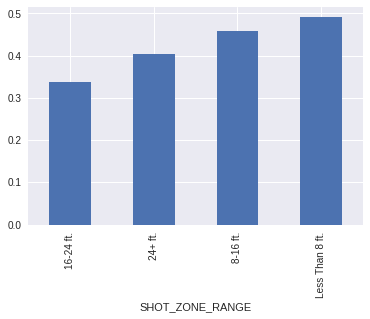

In [10]:
FG.plot.bar()